In [1]:
from uproot_io import Events, View
import numpy as np
from numpy import *
import matplotlib
import matplotlib.pyplot as plt
titlesize = 20
labelsize = 14

In [2]:
events = Events(r"C:\Users\andre\Desktop\Physics Project\bigdata\CheatedRecoFile_1.root")

In [53]:
def fit_line(x, y):
    A = np.vstack([x, np.ones_like(x)]).T
    m, c = np.linalg.lstsq(A, y, rcond=None)[0]
    return m, c

def calculate_residuals(x, y, m, c):
    #y_predicted = (m*x) + c
    perpdist = abs(((-m*x) + y - c) / np.sqrt(m**2 + 1))
    #residuals = np.abs(perpdist - y_predicted)
    return perpdist

def inlierplot(event_number):
    idx = np.where(events.event_number == event_number)[0]
    resis = []
    gradients = []
    intercepts = []
    particleType = []
    
    xmax = -1000
    xmin = 1000
    zmax = -1000
    zmin = 1000
    for i in idx:
        x0 = events.reco_hits_x_w[i]
        z0 = events.reco_hits_w[i]
        if len(x0) > 0:
            if max(x0) >= xmax:
                xmax = max(x0)
            if min(x0) <= xmin:
                xmin = min(x0)
        if len(z0) > 0:
            if max(z0) >= zmax:
                zmax = max(z0)
            if min(z0) <= zmin:
                zmin = min(z0)

    xlen = 0.1*(xmax - xmin)
    zlen = 0.1*(zmax - zmin)
    
    for i in idx:
        x = events.reco_hits_x_w[i]
        z = events.reco_hits_w[i]
        pdg = events.mc_pdg[i]
        
        particleType.append(pdg)
        if pdg == 0:
            gradients.append(0)
            intercepts.append(0)
            resis.append(0)
        
        else:
            best_inliers = []
            best_model = None
            sample_size = 10
            max_iterations = 100
            #inlier_threshold = 2.0

            for _ in range(max_iterations):
                sample_size = min(sample_size, len(x))
                sample_indices = np.random.choice(len(x), size=sample_size, replace=False)
                x_sample = x[sample_indices]
                z_sample = z[sample_indices]

                m, c = fit_line(x_sample, z_sample)
                residuals = calculate_residuals(x, z, m, c)
                inliers = np.where(residuals < (0.15*xlen))[0]

                if len(inliers) > len(best_inliers):
                    best_inliers = inliers
                    best_model = (m, c)

            if len(best_inliers) > 0:
                m, c = best_model
                gradients.append(m)
                intercepts.append(c)
                resis.append(1)

            else:
                gradients.append(0)
                intercepts.append(0)
                resis.append(0)
    
    return np.array(np.stack((gradients, intercepts, resis, particleType)))

In [87]:
import math
#all 0 = unimportant particle
#all 1 = failed fit

def coords(event_number):
    array = inlierplot(event_number)
    m = array[0, :]
    c = array[1, :]
    r = array[2, :]
    part = array[3, :]
    
    lall = []
    tall = []
    #volume = []
    ratio = []
    
    #print(part)
    idx = np.where(events.event_number == event_number)[0]
    newidx = idx - idx[0]
    for i in newidx:
        if part[i] != 0 and r[i] != 0:
            x = events.reco_hits_x_w[i+idx[0]]
            z = events.reco_hits_w[i+idx[0]]
            
            if len(x) > 10:
                znew = z - c[i]

                angle = -math.atan(m[i])

                l = x * np.cos(angle) - znew * np.sin(angle)
                t = x * np.sin(angle) + znew * np.cos(angle)

                lall.append(l)
                tall.append(t)
                #plt.scatter(l,t)

                tdiff = np.abs(max(t)-min(t))
                #ldiff = np.abs(max(l)-min(l))

                #margin = (np.percentile(t, 75)-np.percentile(t, 25))*0.25
                margin = tdiff*0.1

                #h = np.linspace(0, np.round(max(l)), 100)
                #y1 = np.full_like(h, margin)
                #y2 = np.full_like(h, -margin)

                #plt.plot(h, y1)
                #plt.plot(h, y2)
                #plt.show()


                inside = [x for x in t if x <= margin and x >= -margin]
                #outside = [x for x in t if x > margin or x < -margin]

                ratio.append(len(inside)/len(t))

                #volume.append((((tdiff)*(ldiff))/((ldiff)**2 + (tdiff)**2)))

    
    newpart = part[part != 0]
    
    return newpart, ratio
    #return newpart, lall, tall
    #return newpart, volume

part, vol = coords(3633)
print(part)
print(vol)

[  22.   22.  211. 2212. 2212. 2212. 2212. 2212.   11.  211. 2212. 2212.
 2212. 2212. 2212. 2212.]
[0.9238754325259516, 0.6052631578947368, 0.4, 0.7096774193548387, 0.73, 0.2727272727272727]


In [88]:
def histplot(num, extra):
    tracks = []
    showers = []
    
    for n in range(num):
        part, vol = coords(n+extra)
        for i in range(len(vol)):
            #if sd[i] != 0. and sd[i] != -0. and total[i] <= 20:
            if part[i] == 22. or part[i] == -11. or part[i] == 11.:
                showers.append(vol[i])
            else:
                tracks.append(vol[i])
    
    #print(max(showers))
    bin_edges = np.arange(0, 1.05, 0.05)
    hist1, _ = np.histogram(tracks, bins=bin_edges)
    hist2, _ = np.histogram(showers, bins=bin_edges)
   
    hist1_normalized = hist1 / len(tracks)
    hist2_normalized = hist2 / len(showers)

    plt.bar(bin_edges[:-1], hist1_normalized, width=0.05, align='edge', alpha=0.75, label='Tracks')
    plt.bar(bin_edges[:-1], hist2_normalized, width=0.05, align='edge', alpha=0.75, label='Showers')
    
    plt.xlabel('Ratio of particles close to fitted line')
    plt.legend()
    plt.show()

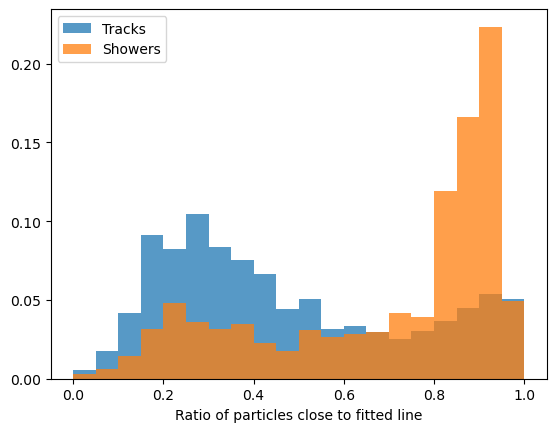

In [90]:
histplot(1000, 433)